In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os

In [3]:
file_train = "감성대화말뭉치_train.xlsx"
file_test = "감성대화말뭉치_valid.xlsx"
path = "/content/drive/MyDrive/AI프로젝트/일기_NLP/Sentiment_Analysis/Data/"
train_df = pd.read_excel(os.path.join(path, file_train))
test_df = pd.read_excel(os.path.join(path, file_test))

In [4]:
def select_columns(df, columns):
  return df[columns]

In [5]:
cols = ["감정_대분류", "사람문장1","시스템문장1", "사람문장2", "시스템문장2", "사람문장3"]
train_df = select_columns(train_df, cols)
test_df = select_columns(test_df, cols)

In [6]:
def replace_last_system_with_nan(df):
    # 사람 문장과 시스템 문장 열 이름 리스트
    people_columns = [col for col in df.columns if col.startswith('사람문장')]
    system_columns = [col for col in df.columns if col.startswith('시스템문장')]

    # 마지막 발화가 시스템 문장인 경우 NaN으로 변경
    for index, row in df.iterrows():
        for col in reversed(df.columns):
            if col in system_columns and pd.notna(row[col]):
                df.at[index, col] = np.nan
                break
            elif col in people_columns and pd.notna(row[col]):
                break
    return df

In [7]:
# 발화 구분 토큰 추가 및 병합 함수
def merge_conversations(row):
    conversation = ""
    if pd.notna(row['사람문장1']):
        conversation += "[USR] " + row['사람문장1'] + " "
    if pd.notna(row['시스템문장1']):
        conversation += "[BOT] " + row['시스템문장1'] + " "
    if pd.notna(row['사람문장2']):
        conversation += "[USR] " + row['사람문장2'] + " "
    if pd.notna(row['시스템문장2']):
        conversation += "[BOT] " + row['시스템문장2'] + " "
    if pd.notna(row['사람문장3']):
        conversation += "[USR] " + row['사람문장3']
    return conversation.strip()

In [8]:
train_df = replace_last_system_with_nan(train_df)
test_df = replace_last_system_with_nan(test_df)
train_df["text"] = train_df.apply(merge_conversations, axis=1)
test_df["text"] = test_df.apply(merge_conversations, axis=1)

In [9]:
train_df = train_df[["감정_대분류", "text"]]
test_df = test_df[["감정_대분류", "text"]]

In [10]:
train_df = train_df.dropna(axis=0)
test_df = test_df.dropna(axis=0)
train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()

In [11]:
def rename_columns(df):
    df.columns = ['label_name', 'text']
    return df
train_df = rename_columns(train_df)
test_df = rename_columns(test_df)

In [12]:
train_df.groupby('label_name').count()

text
label_name      
기쁨          6126
당황          8756
분노          9160
불안          9320
상처          9142
슬픔          9125

In [13]:
test_df.groupby('label_name').count()

text
label_name      
기쁨          1213
당황          1048
분노          1257
불안          1113
상처          1007
슬픔          1003

## 중립 데이터가 빠져있음.

In [14]:
neutral_df = pd.read_excel(os.path.join(path, "한국어_연속적_대화_데이터셋.xlsx"), skiprows=1)

In [15]:
neutral_df.groupby("감정").count()

dialog #     발화  Unnamed: 3  Unnamed: 4  1030  Unnamed: 6  Unnamed: 7  \
감정                                                                           
ㄴ중립         0      1           0           0     0           0           0   
ㅈ중립         0      1           0           0     0           0           0   
ㅍ           3     12           0           0     0           0           0   
공포         17     98           0           0     0           0           0   
놀람       1009   4866           0           0     0           0           0   
분           0      4           0           0     0           0           0   
분ㄴ          0      1           0           0     0           0           0   
분노        603   3628           0           0     0           0           0   
슬픔        260   1972           0           0     0           0           0   
줄           0      1           0           0     0           0           0   
중림          0      1           0           0     0           0           0   
중립       7916  43786           0           0     0           0           0   
행복        151   1030           0           0     0           0           0   
혐오         38    220           0           0     0           0           0   

     Unnamed: 8  Unnamed: 9  Unnamed: 10  Unnamed: 11  
감정                                                     
ㄴ중립           0           0            0            0  
ㅈ중립           0           0            0            0  
ㅍ             0           0            0            0  
공포            0           0            0            0  
놀람            0           0            0            0  
분             0           0            0            0  
분ㄴ            0           0            0            0  
분노            0           0            0            0  
슬픔            0           0            0            0  
줄             0           0            0            0  
중림            0           0            0            0  
중립            0           0            0            0  
행복            0           0            0            0  
혐오            0           0            0            0

In [16]:
neutral_df = neutral_df[["dialog #", "감정", "발화"]]

In [17]:
neutral_df.groupby("감정").count()
neutral_df = select_columns(neutral_df, ["dialog #", "감정", "발화"])

In [18]:
def correct_label(x):
  if x == "ㄴ중립" or x == "ㅈ중립" or x=="중림" or x=="줄":
    return "중립"
  elif x == "분" or x == "분ㄴ":
    return "분노"
  else:
    return x

In [19]:
neutral_df["감정"] = neutral_df["감정"].apply(correct_label)
update_indices = [25036, 27176, 27947, 28089, 28454, 28481, 36683, 37260, 37427, 37863, 41754, 43150]
new_labels = ['중립', '놀람', '중립', '중립', '슬픔', '혐오', '행복', '분노', '놀람', '혐오', '혐오', '슬픔']

# 데이터프레임 업데이트
for i in range(len(update_indices)):
    neutral_df.loc[update_indices[i], '감정'] = new_labels[i]

In [20]:
S_indices = sorted(neutral_df[neutral_df["dialog #"] == "S"].index.tolist())
print(neutral_df[neutral_df["dialog #"] == "S"].index.tolist()[:5])
print(len(S_indices))

[0, 7, 15, 29, 41]
10000


In [ ]:
def check(tmp_emos):
  x = "중립"
  for emo in tmp_emos:
    if emo != x:
      return False
  return True

def find_emotions(emo_set):
  current_emo = None
  for emo in emo_set:
    if emo != "중립":
      current_emo = emo
  return current_emo

def find_emotions_indexes(emotion_list, target_emo):
  indexes = []
  for i in range(len(emotion_list)):
    if emotion_list[i] == target_emo:
      indexes.append(i)
  if len(indexes) == 0:
    return [-1]
  else:
    return indexes

def make_windows(neutral_df, S_indices, window_size):
    data = []
    emos = []
    nums = []; conversation_num = -1
    emotion_idx = []
    for i in range(len(S_indices) - 1):
        start_index = S_indices[i]
        end_index = S_indices[i + 1] - 1
        conversation_num += 1
        if end_index - start_index <= window_size - 1:
            continue
        else:
            for j in range(start_index, end_index - window_size + 2):
                strs = []; tmp_emos = []
                for k in range(window_size):
                    if k == 0:
                      strs.append("[SEP] " + str(neutral_df.loc[j + k, "발화"]))
                    else:
                      strs.append(str(neutral_df.loc[j + k, "발화"]))
                    tmp_emos.append(neutral_df.loc[j + k, "감정"])
                if check(tmp_emos):
                  emos.append("중립")
                  emotion_idx.append([-1])
                else:
                  emos_set = list(set(tmp_emos))
                  if len(emos_set) == 2:
                    target_emo = find_emotions(emos_set)
                    emo_idx = find_emotions_indexes(tmp_emos, target_emo)
                    emos.append(target_emo)
                    emotion_idx.append(emo_idx)
                  else:
                    emos.append("두가지_이상의_감정")
                    emotion_idx.append([-1])
                data.append(" [SEP] ".join(strs))
                nums.append(conversation_num)
    return data, emos, nums, emotion_idx

# 슬라이딩 윈도우 크기 1
windows3, emos3, nums3, emos3_idx = make_windows(neutral_df, S_indices, 3)
windows5, emos5, nums5, emos5_idx = make_windows(neutral_df, S_indices, 5)
windows7, emos7, nums7, emos7_idx = make_windows(neutral_df, S_indices, 7)

In [ ]:
example_nums = 10
for i in range(example_nums):
    print(emos3[i], windows3[i], nums3[i], emos3_idx[i])
for i in range(example_nums):
    print(emos5[i], windows5[i], nums5[i], emos5_idx[i])
for i in range(example_nums):
    print(emos7[i], windows7[i], nums7[i], emos7_idx[i])

두가지_이상의_감정 [SEP] 아 진짜! 사무실에서 피지 말라니깐! 간접흡연이 얼마나 안좋은데! [SEP] 그럼 직접흡연하는 난 얼마나 안좋겠니? 안그래? 보면 꼭... 지 생각만 하고. [SEP] 손님 왔어요. 0 [-1]
혐오 [SEP] 그럼 직접흡연하는 난 얼마나 안좋겠니? 안그래? 보면 꼭... 지 생각만 하고. [SEP] 손님 왔어요. [SEP] 손님? 누구? 0 [0]
중립 [SEP] 손님 왔어요. [SEP] 손님? 누구? [SEP] 몰라요. 팀장님 친구래요. 0 [-1]
중립 [SEP] 손님? 누구? [SEP] 몰라요. 팀장님 친구래요. [SEP] 내 친구? 친구 누구? 0 [-1]
분노 [SEP] 몰라요. 팀장님 친구래요. [SEP] 내 친구? 친구 누구? [SEP] 그걸 내가 어떻게 알아요! 0 [2]
중립 [SEP] 그래서... 무슨 일 해? [SEP] 그냥 방송일 조금.  [SEP] 방송? 방송 뭐? 1 [-1]
중립 [SEP] 그냥 방송일 조금.  [SEP] 방송? 방송 뭐? [SEP] 케이블 같은데서 아침에 배도 타고 산도 오르고. 있어 그런 거. 1 [-1]
중립 [SEP] 방송? 방송 뭐? [SEP] 케이블 같은데서 아침에 배도 타고 산도 오르고. 있어 그런 거. [SEP] 사는 덴 어디야? 1 [-1]
중립 [SEP] 케이블 같은데서 아침에 배도 타고 산도 오르고. 있어 그런 거. [SEP] 사는 덴 어디야? [SEP] 개포동. 1 [-1]
중립 [SEP] 사는 덴 어디야? [SEP] 개포동. [SEP] 남편은 뭐하는데? 1 [-1]
두가지_이상의_감정 [SEP] 아 진짜! 사무실에서 피지 말라니깐! 간접흡연이 얼마나 안좋은데! [SEP] 그럼 직접흡연하는 난 얼마나 안좋겠니? 안그래? 보면 꼭... 지 생각만 하고. [SEP] 손님 왔어요. [SEP] 손님? 누구? [SEP] 몰라요. 팀장님 친구래요. 0 [-1]
혐오 [SEP] 그럼 직접흡연하는 난 얼마나 안좋겠니? 안그래? 보면 꼭... 지 생각만 하고. [SEP] 손님 왔어

In [ ]:
len(windows3), len(emos3_idx)

(35613, 35613)

In [ ]:
windows3_df = pd.DataFrame({"발화": windows3, "감정": emos3, "발화번호": nums3, "감정인덱스": emos3_idx})
windows5_df = pd.DataFrame({"발화": windows5, "감정": emos5, "발화번호": nums5, "감정인덱스": emos5_idx})
windows7_df = pd.DataFrame({"발화": windows7, "감정": emos7, "발화번호": nums7, "감정인덱스": emos7_idx})
print(windows3_df.shape)
print(windows5_df.shape)
print(windows7_df.shape)

(35613, 4)
(12748, 4)
(3170, 4)


In [ ]:
neutral_df = pd.concat([windows3_df, windows5_df, windows7_df], axis=0)

In [ ]:
neutral_df[["발화", "감정", "발화번호"]] = neutral_df[["발화", "감정", "발화번호"]].drop_duplicates()

In [ ]:
neutral_df.shape

(51531, 4)

In [ ]:
neutral_df["발화"] = neutral_df["발화"].apply(lambda x : x.replace("[SEP]", "[USR]"))
neutral_df["감정"] = neutral_df["감정"].apply(lambda x : x if x != "혐오" else "분노")
neutral_df["감정"] = neutral_df["감정"].apply(lambda x : x if x != "공포" else "불안")
neutral_df["감정"] = neutral_df["감정"].apply(lambda x : x if x != "행복" else "기쁨")
neutral_df["감정"] = neutral_df["감정"].apply(lambda x : x if x != "놀람" else "당황")

In [ ]:
neutral_df.groupby("감정").count()

발화   발화번호  감정인덱스
감정                             
기쁨           1550   1550   1550
당황          11570  11570  11570
두가지_이상의_감정   4779   4779   4779
분노           5323   5323   5323
불안            154    154    154
슬픔           2987   2987   2987
중립          25152  25152  25152

In [ ]:
neutral_df = neutral_df[neutral_df["감정"] != "두가지_이상의_감정"]
neutral_df.head()

발화  감정  발화번호 감정인덱스
1  [USR] 그럼 직접흡연하는 난 얼마나 안좋겠니? 안그래? 보면 꼭... 지 생각만...  분노     0   [0]
2   [USR] 손님 왔어요. [USR] 손님? 누구? [USR] 몰라요. 팀장님 친구래요.  중립     0  [-1]
3  [USR] 손님? 누구? [USR] 몰라요. 팀장님 친구래요. [USR] 내 친구?...  중립     0  [-1]
4  [USR] 몰라요. 팀장님 친구래요. [USR] 내 친구? 친구 누구? [USR] ...  분노     0   [2]
5  [USR] 그래서... 무슨 일 해? [USR] 그냥 방송일 조금.  [USR] 방...  중립     1  [-1]

In [ ]:
not_neutral_df = neutral_df[neutral_df["감정"] != "중립"]

def fine_not_valid_case(index_list):
  for index in index_list:
    if index % 2 == 1:
      return 0
  return 1
not_neutral_df["is_valid"] = not_neutral_df["감정인덱스"].apply(fine_not_valid_case)

<ipython-input-348-d78376207819>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_neutral_df["is_valid"] = not_neutral_df["감정인덱스"].apply(fine_not_valid_case)


In [ ]:
not_neutral_valid_df = not_neutral_df[not_neutral_df["is_valid"] == 1]

In [ ]:
print(not_neutral_valid_df.shape)
not_neutral_valid_df.head(100)

(12028, 5)


발화  감정  발화번호   감정인덱스  \
1    [USR] 그럼 직접흡연하는 난 얼마나 안좋겠니? 안그래? 보면 꼭... 지 생각만...  분노     0     [0]   
4    [USR] 몰라요. 팀장님 친구래요. [USR] 내 친구? 친구 누구? [USR] ...  분노     0     [2]   
10   [USR] 개포동. [USR] 남편은 뭐하는데? [USR] 동사무소에서 인구조사 나...  분노     1     [2]   
13   [USR] 그럼 내가 널 왜 만나러 왔겠어? [USR] 근데 왜... 나한테...?...  분노     2  [0, 2]   
15   [USR] 내가 몇 명 만나봤는데, 보니까 죄다 사기꾼 같고 영 못 믿겠어. 아무래...  분노     2     [0]   
..                                                 ...  ..   ...     ...   
440  [USR] 아우 귀 아퍼요. 왜 소리를 지르고 그러세요. [USR] 내가 소리 안 ...  당황   132  [0, 2]   
442  [USR] 무...무슨 기분 나쁜 일 있으셨어요? [USR] 왜 오늘 아침에는 밥하...  당황   132  [0, 2]   
444  [USR] 늦...늦게 일어났어요. [USR] 밤에 잠 안자고 뭐 했는데. [USR...  당황   132     [0]   
448  [USR] 스물 일곱요. [USR] 가만있자 스물일곱..스물일곱? [USR] 왜요?...  당황   133     [2]   
452  [USR] 그럼 문자로 남기세요. [USR] 나는 문자 못 남긴다구요. 핸드폰 자판...  분노   134     [2]   

     is_valid  
1           1  
4           1  
10          1  
13          1  
15          1  
..        ...  
440         1  
442         1  
444         1  
448         1  
452         1  

[100 rows x 5 columns]

In [ ]:
not_neutral_valid_df.groupby("감정").count()

발화  발화번호  감정인덱스  is_valid
감정                             
기쁨   863   863    863       863
당황  6494  6494   6494      6494
분노  3025  3025   3025      3025
불안    81    81     81        81
슬픔  1565  1565   1565      1565

In [ ]:
def transform_bot_token(x):
  str_list = str(x).split()
  stacks = []
  results = []
  for str_x in str_list:
    if str_x == "[USR]":
      stacks.append(str_x)
      if len(stacks) % 2 == 0:
        results.append("[BOT]")
      else:
        results.append("[USR]")
    else:
      results.append(str_x)
  return " ".join(results)
neutral_df["발화"] = neutral_df["발화"].apply(transform_bot_token)
not_neutral_valid_df["발화"] = not_neutral_valid_df["발화"].apply(transform_bot_token)
not_neutral_valid_df = not_neutral_valid_df[["발화", "감정", "발화번호"]]

<ipython-input-352-cec18fc7b48b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_neutral_valid_df["발화"] = not_neutral_valid_df["발화"].apply(transform_bot_token)


In [ ]:
neutral_df = neutral_df[neutral_df["감정"] == "중립"]

In [ ]:
neutral_df.shape, not_neutral_valid_df.shape

((25152, 4), (12028, 3))

In [ ]:
neutral_df.head()

발화  감정  발화번호 감정인덱스
2   [USR] 손님 왔어요. [BOT] 손님? 누구? [USR] 몰라요. 팀장님 친구래요.  중립     0  [-1]
3  [USR] 손님? 누구? [BOT] 몰라요. 팀장님 친구래요. [USR] 내 친구?...  중립     0  [-1]
5  [USR] 그래서... 무슨 일 해? [BOT] 그냥 방송일 조금. [USR] 방송...  중립     1  [-1]
6  [USR] 그냥 방송일 조금. [BOT] 방송? 방송 뭐? [USR] 케이블 같은데...  중립     1  [-1]
7  [USR] 방송? 방송 뭐? [BOT] 케이블 같은데서 아침에 배도 타고 산도 오르...  중립     1  [-1]

In [ ]:
not_neutral_valid_df.head()

발화  감정  발화번호
1   [USR] 그럼 직접흡연하는 난 얼마나 안좋겠니? 안그래? 보면 꼭... 지 생각만...  분노     0
4   [USR] 몰라요. 팀장님 친구래요. [BOT] 내 친구? 친구 누구? [USR] ...  분노     0
10  [USR] 개포동. [BOT] 남편은 뭐하는데? [USR] 동사무소에서 인구조사 나...  분노     1
13  [USR] 그럼 내가 널 왜 만나러 왔겠어? [BOT] 근데 왜... 나한테...?...  분노     2
15  [USR] 내가 몇 명 만나봤는데, 보니까 죄다 사기꾼 같고 영 못 믿겠어. 아무래...  분노     2

In [ ]:
neutral_df = pd.concat([neutral_df[["발화", "감정", "발화번호"]], not_neutral_valid_df], axis=0)

In [ ]:
neutral_df.groupby("감정").count()

발화   발화번호
감정              
기쁨    863    863
당황   6494   6494
분노   3025   3025
불안     81     81
슬픔   1565   1565
중립  25152  25152

In [ ]:
import pandas as pd
import copy
from sklearn.model_selection import train_test_split

df = copy.deepcopy(neutral_df)

# 고유한 발화번호 추출
unique_utterances = df.drop_duplicates(subset=['발화번호'])

# 발화번호를 기준으로 test 세트 2500개 분리
train_valid, test = train_test_split(unique_utterances, test_size=800, random_state=42)

# 나머지 데이터를 train과 valid로 4:1 비율로 분리
train, valid = train_test_split(train_valid, test_size=0.2, random_state=42)

# 원래 데이터프레임에서 발화번호를 기준으로 매핑
train_neutral_set = df[df['발화번호'].isin(train['발화번호'])]
valid_neutral_set = df[df['발화번호'].isin(valid['발화번호'])]
test_neutral_set = df[df['발화번호'].isin(test['발화번호'])]
print(train_neutral_set.nunique())
print(valid_neutral_set.nunique())
print(test_neutral_set.nunique())

발화      27086
감정          6
발화번호     7042
dtype: int64
발화      6917
감정         6
발화번호    1761
dtype: int64
발화      2998
감정         6
발화번호     800
dtype: int64


In [ ]:
train_neutral_set = train_neutral_set[["발화", "감정"]]
valid_neutral_set = valid_neutral_set[["발화", "감정"]]
test_neutral_set = test_neutral_set[["발화", "감정"]]
train_neutral_set.columns = ["text", "label_name"]
valid_neutral_set.columns = ["text", "label_name"]
test_neutral_set.columns = ["text", "label_name"]

# 중립데이터도 포함하여 구성

In [ ]:
train_df.shape

(51629, 2)

In [ ]:
# 데이터프레임을 4:1 비율로 나누기
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [ ]:
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
train_neutral_set.groupby("label_name").count()

text
label_name       
기쁨            628
당황           4699
분노           2239
불안             55
슬픔           1145
중립          18476

In [ ]:
train_df = pd.concat([train_df, train_neutral_set], ignore_index=True).reset_index(drop=True)
valid_df = pd.concat([valid_df, valid_neutral_set], ignore_index=True).reset_index(drop=True)
test_df = pd.concat([test_df, test_neutral_set], ignore_index=True).reset_index(drop=True)

In [ ]:
train_df.groupby('label_name').count()

text
label_name       
기쁨           5512
당황          11754
분노           9561
불안           7527
상처           7307
슬픔           8408
중립          18476

In [ ]:
test_df.groupby('label_name').count()

text
label_name      
기쁨          1270
당황          1635
분노          1509
불안          1117
상처          1007
슬픔          1143
중립          1958

In [ ]:
emo2int = {
    "기쁨": 0, "당황": 1, "분노": 2,
    "불안": 3, "상처": 4, "슬픔": 5,
    "중립": 6
}
kore2en = {
    "기쁨": "joy", "당황": "surprise", "분노": "anger",
    "불안": "fear", "상처": "hurt", "슬픔": "sadness",
    "중립": "neutral"
}
f = lambda x : emo2int[x]
def label_to_int(x):
  return f(x)

train_df["label_int"] = train_df["label_name"].apply(label_to_int)
test_df["label_int"] = test_df["label_name"].apply(label_to_int)
train_df["en_label"] = train_df["label_name"].apply(lambda x : kore2en[x])
test_df["en_label"] = test_df["label_name"].apply(lambda x : kore2en[x])

<Axes: title={'center': 'Words Per Data'}, xlabel='en_label'>

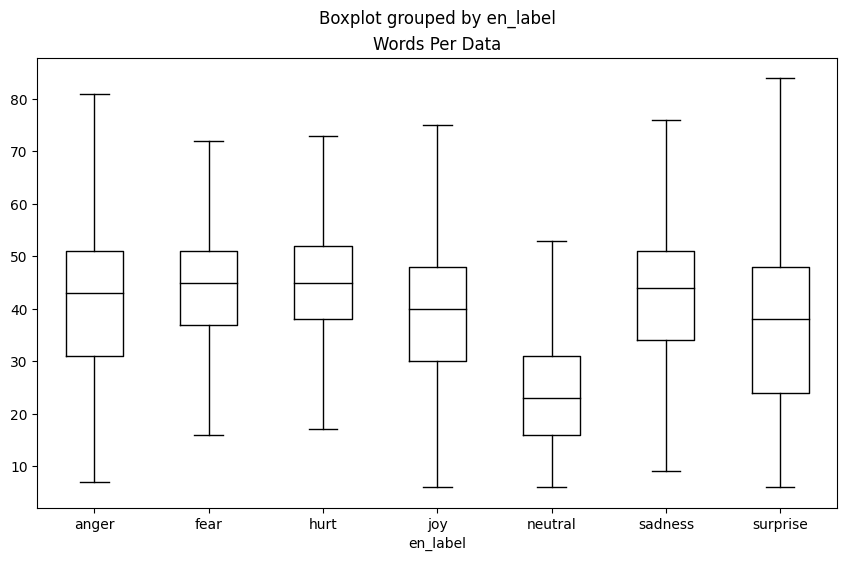

In [ ]:
train_df["Words Per Data"] = train_df["text"].str.split().apply(len)
train_df.boxplot("Words Per Data", by="en_label", grid=False,
           showfliers=False, figsize=(10, 6), color="black")

KeyError: 'en_label'

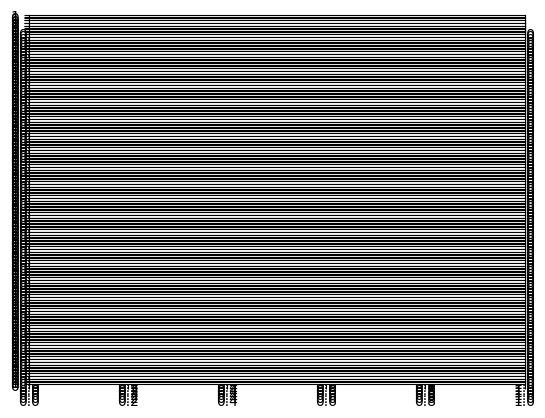

In [ ]:
import matplotlib.pyplot as plt
train_df["en_label"].value_counts().plot(kind="bar")
plt.show()

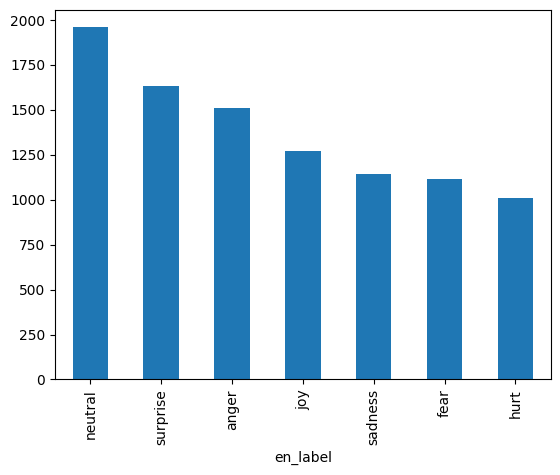

In [ ]:
test_df["en_label"].value_counts().plot(kind="bar")
plt.show()

In [ ]:
train_df.columns

Index(['label_name', 'text', 'label_int', 'en_label', 'Words Per Data'], dtype='object')

In [ ]:
test_df.columns

Index(['label_name', 'text', 'label_int', 'en_label'], dtype='object')

In [ ]:
selected_cols = ["text", "label_int"]
train_df = train_df[selected_cols]
test_df = test_df[selected_cols]
train_df.columns = ["text", "label"]
test_df.columns = ["text", "label"]

In [ ]:
valid_df["label_int"] = valid_df["label_name"].apply(label_to_int)
valid_df["en_label"] = valid_df["label_name"].apply(lambda x : kore2en[x])

In [ ]:
valid_df = valid_df[selected_cols]
valid_df.columns = ["text", "label"]

In [ ]:
train_df.to_csv(os.path.join(path, "train_data_preprocessed_v1.3.csv"), index=False)
valid_df.to_csv(os.path.join(path, "valid_data_preprocessed_v1.3.csv"), index=False)
test_df.to_csv(os.path.join(path, "test_data_preprocessed_v1.3.csv"), index=False)

In [ ]:
test_df.head(100)

text  label
0   [USR] 이번 프로젝트에서 발표를 하는데 내가 실수하는 바람에 우리 팀이 감점을 ...      3
1   [USR] 회사에서 중요한 프로젝트를 혼자 하게 됐는데 솔직히 두렵고 무서워. [B...      3
2   [USR] 상사가 너무 무섭게 생겨서 친해지는 게 너무 두려워. [BOT] 직장 상...      3
3   [USR] 이번에 힘들게 들어간 첫 직장이거든. 첫 직장이라서 그런지 너무 긴장된다...      3
4   [USR] 직장에서 동료들이랑 관계가 안 좋아질까 봐 걱정돼. [BOT] 직장 사람...      3
..                                                ...    ...
95  [USR] 빨리 취업을 해야 학자금 대출을 갚는데 취업이 안 돼서 속상하고 불안해....      2
96  [USR] 누군가의 거짓 진술로 인해 친구들로부터 따돌림을 당하게 되었어. [BOT...      4
97  [USR] 나는 일 년 동안 따돌림을 당해서 마음 속 상처가 많아. [BOT] 따돌...      4
98  [USR] 가장 친한 친구가 내가 그 책을 훔쳐갔다고 얘기해서 너무 슬펐어. [BO...      4
99  [USR] 나는 맹세코 그런 말을 한 적이 없는데 왜 걔한테 맞았는지 모르겠어. 너...      4

[100 rows x 2 columns]

In [ ]:
valid_df.groupby("label").count()

text
label      
0      1420
1      2909
2      2372
3      1870
4      1835
5      2142
6      4718